In [1]:
import os
workdir = "datasets/Project/"        
os.chdir(workdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
def loaddata(path, seed=9527):
    """
    Usage: there should be ./breast/ and ./prostate/ under the path
    """
    
    np.random.seed(seed=seed)
    
    def image2tensor(tumor, cnv):
        train1, train2, train3, testset1, testset2, testset3 = [], [], [], [], [], []
        train = [train1, train2, train3] # 3 channels
        test = [testset1, testset2, testset3]

        rawfnames = !ls ./$tumor/$cnv/*jpg
        rawfnames = np.array(np.sort(rawfnames), dtype=object)
        
        # randomly distribute data to train set and test set in 5:1 ratio
        randomIndices = np.random.permutation(rawfnames.shape[0]//3)
        for i, rawf in enumerate(rawfnames):
            im = cv2.imread(rawf, 0)
            channel = i % 3
            if (randomIndices[i//3]) % 6 == 0:
                test[channel].append(im)
            else:
                train[channel].append(im)
                
        return np.array(train).transpose([1,2,3,0]), np.array(test).transpose([1,2,3,0])
    
    tumors = ["breast", "prostate"]
    cnvs = ["altered", "flat"]
    
    trainset,  testset = {"breast" : {}, "prostate" : {}}, {"breast" : {}, "prostate" : {}}
    data = {"trainset" : trainset , "testset" : testset}
    
    for tumor in tumors:
        for i, cnv in enumerate(cnvs):
            if i == 0:
                trainset[tumor]["pos"], testset[tumor]["pos"] = image2tensor(tumor, cnv)
            if i == 1:
                trainset[tumor]["neg"], testset[tumor]["neg"] = image2tensor(tumor, cnv)
                
    return data

In [3]:
data = loaddata(workdir)

# fig, axes = plt.subplots(2,4, figsize=(12,5))
# i, j = 0, 0

# for subset, d1 in data.items():
#     for tumor, d2 in d1.items():
#         for cnv, imgs in d2.items():
#             print("{} {} {} {}".format(subset, tumor, cnv, imgs.shape))
#             axes[i,j%4].imshow(data[subset][tumor][cnv][0])
#             axes[i,j%4].set_title("{} {} {}".format(subset, tumor, cnv))
#             axes[i,j%4].axis('off')
#             j += 1
#     i += 1

# plt.show()
# plt.close()

# Naive CNN with Batch Normalization

* Not using any data preprocessing or augmentation
* Adding BatchNorm after every ReLU activation

## 1. Breast Cancer

In [4]:
tumor = "breast"

xtrain_pos, xtrain_neg = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train = np.concatenate((xtrain_pos, xtrain_neg), axis=0)
y_train = np.concatenate((np.ones(xtrain_pos.shape[0], dtype=int), np.zeros(xtrain_neg.shape[0], dtype=int)))
x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 3
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Train on 939 samples, validate on 189 samples
Epoch 1/3
939/939 [==============================] - 168s 179ms/step - loss: 0.7063 - acc: 0.7753 - val_loss: 0.9750 - val_acc: 0.7513
Epoch 2/3
939/939 [==============================] - 164s 175ms/step - loss: 0.3215 - acc: 0.8839 - val_loss: 0.8019 - val_acc: 0.7407
Epoch 3/3
189/189 [==============================] - 8s 42ms/step
Test loss: 0.8286747850438274
Test accuracy: 0.7513227532149622


In [6]:
# Save model and weights

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_breast.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/zifanzhu/Desktop/DL_project/datasets/Project/saved_models/naive_cnn_with_batchnorm_breast.h5 


## 2. Prostate Cancer

In [4]:
tumor = "prostate"

xtrain_pos, xtrain_neg = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train = np.concatenate((xtrain_pos, xtrain_neg), axis=0)
y_train = np.concatenate((np.ones(xtrain_pos.shape[0], dtype=int), np.zeros(xtrain_neg.shape[0], dtype=int)))
x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 3
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Train on 608 samples, validate on 123 samples
Epoch 1/3
608/608 [==============================] - 209s 344ms/step - loss: 0.8720 - acc: 0.6628 - val_loss: 0.8856 - val_acc: 0.7073
Epoch 2/3
608/608 [==============================] - 110s 181ms/step - loss: 0.3437 - acc: 0.8487 - val_loss: 0.6977 - val_acc: 0.7724
Epoch 3/3
123/123 [==============================] - 5s 41ms/step
Test loss: 0.7554102537593221
Test accuracy: 0.7479674811285686


In [6]:
# Save model and weights

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_prostate.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/zifanzhu/Desktop/DL_project/datasets/Project/saved_models/naive_cnn_with_batchnorm_prostate.h5 


## 3. Model transfer: prostate model test on breast

In [7]:
from keras.models import load_model
import keras

# load trained model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_prostate.h5'
model_path = os.path.join(save_dir, model_name)

del model
model = load_model(model_path)

In [8]:
tumor = "breast"

xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))
y_test = keras.utils.to_categorical(y_test, 2)

In [9]:
# evaluate on test set

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

189/189 [==============================] - 9s 46ms/step
Test loss: 0.7713835504319932
Test accuracy: 0.7089947080486035


## 4. Model transfer: breast model test on prostate

In [7]:
from keras.models import load_model
import keras

# load trained model

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'naive_cnn_with_batchnorm_breast.h5'
model_path = os.path.join(save_dir, model_name)

del model
model = load_model(model_path)

In [8]:
tumor = "prostate"

xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))
y_test = keras.utils.to_categorical(y_test, 2)

In [9]:
# evaluate on test set

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

123/123 [==============================] - 6s 48ms/step
Test loss: 1.0489666206323034
Test accuracy: 0.7235772406182638


## 5. Summary

* Both dataset can achieve about 0.75 accuracy.
* Model transfer cannot improve accuracy.

## 6. Mix two datasets

In [4]:
tumor = "breast"

xtrain_pos_b, xtrain_neg_b = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos_b, xtest_neg_b = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train_b = np.concatenate((xtrain_pos_b, xtrain_neg_b), axis=0)
y_train_b = np.concatenate((np.ones(xtrain_pos_b.shape[0], dtype=int), np.zeros(xtrain_neg_b.shape[0], dtype=int)))
x_test_b = np.concatenate((xtest_pos_b, xtest_neg_b), axis=0)
y_test_b = np.concatenate((np.ones(xtest_pos_b.shape[0], dtype=int), np.zeros(xtest_neg_b.shape[0], dtype=int)))

tumor = "prostate"

xtrain_pos_p, xtrain_neg_p = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos_p, xtest_neg_p = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train_p = np.concatenate((xtrain_pos_p, xtrain_neg_p), axis=0)
y_train_p = np.concatenate((np.ones(xtrain_pos_p.shape[0], dtype=int), np.zeros(xtrain_neg_p.shape[0], dtype=int)))
x_test_p = np.concatenate((xtest_pos_p, xtest_neg_p), axis=0)
y_test_p = np.concatenate((np.ones(xtest_pos_p.shape[0], dtype=int), np.zeros(xtest_neg_p.shape[0], dtype=int)))

x_train = np.concatenate((x_train_b, x_train_p), axis=0)
y_train = np.concatenate((y_train_b, y_train_p), axis=0)
x_test = np.concatenate((x_test_b, x_test_p), axis=0)
y_test = np.concatenate((y_test_b, y_test_p), axis=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1547, 225, 225, 3)
(1547,)
(312, 225, 225, 3)
(312,)


In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 10
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Train on 1547 samples, validate on 312 samples
Epoch 1/10
1547/1547 [==============================] - 244s 158ms/step - loss: 0.7222 - acc: 0.7460 - val_loss: 0.9363 - val_acc: 0.7019
Epoch 2/10
1547/1547 [==============================] - 238s 154ms/step - loss: 0.4088 - acc: 0.8416 - val_loss: 0.7526 - val_acc: 0.7340
Epoch 3/10
1547/1547 [==============================] - 233s 150ms/step - loss: 0.3065 - acc: 0.8869 - val_loss: 0.7372 - val_acc: 0.7372
Epoch 4/10
1547/1547 [==============================] - 230s 148ms/step - loss: 0.2072 - acc: 0.9179 - val_loss: 0.7369 - val_acc: 0.7500
Epoch 5/10
1547/1547 [==============================] - 229s 148ms/step - loss: 0.1738 - acc: 0.9399 - val_loss: 0.8014 - val_acc: 0.7404

## 7. Center-crop for breast cancer

In [10]:
tumor = "breast"

xtrain_pos, xtrain_neg = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train = np.concatenate((xtrain_pos, xtrain_neg), axis=0)[:,100:130,100:130,:]
y_train = np.concatenate((np.ones(xtrain_pos.shape[0], dtype=int), np.zeros(xtrain_neg.shape[0], dtype=int)))
x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)[:,100:130,100:130,:]
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))

In [11]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 7
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Train on 939 samples, validate on 189 samples
Epoch 1/7
939/939 [==============================] - 4s 4ms/step - loss: 0.5799 - acc: 0.8094 - val_loss: 0.8028 - val_acc: 0.7725
Epoch 2/7
939/939 [==============================] - 3s 3ms/step - loss: 0.5407 - acc: 0.8328 - val_loss: 0.6687 - val_acc: 0.7619
Epoch 3/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4857 - acc: 0.8371 - val_loss: 0.7507 - val_acc: 0.7725
Epoch 4/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4991 - acc: 0.8435 - val_loss: 0.7301 - val_acc: 0.7831
Epoch 5/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4690 - acc: 0.8562 - val_loss: 0.7127 - val_acc: 0.7725
Epoch 6/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4714 - acc: 0.8477 - val_loss: 0.5994 - val_acc: 0.7778
Epoch 7/7
189/189 [==============================] - 0s 549us/step
Test loss: 0.7210682753532652
Test accuracy: 0.7777777768316723


## 8. Center-crop for prostate cancer

In [12]:
tumor = "breast"

xtrain_pos, xtrain_neg = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos, xtest_neg = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

x_train = np.concatenate((xtrain_pos, xtrain_neg), axis=0)[:,100:130,100:130,:]
y_train = np.concatenate((np.ones(xtrain_pos.shape[0], dtype=int), np.zeros(xtrain_neg.shape[0], dtype=int)))
x_test = np.concatenate((xtest_pos, xtest_neg), axis=0)[:,100:130,100:130,:]
y_test = np.concatenate((np.ones(xtest_pos.shape[0], dtype=int), np.zeros(xtest_neg.shape[0], dtype=int)))

In [13]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 7
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Train on 939 samples, validate on 189 samples
Epoch 1/7
939/939 [==============================] - 4s 4ms/step - loss: 0.6661 - acc: 0.7891 - val_loss: 0.9707 - val_acc: 0.7566
Epoch 2/7
939/939 [==============================] - 3s 3ms/step - loss: 0.5117 - acc: 0.8211 - val_loss: 0.7810 - val_acc: 0.7566
Epoch 3/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4723 - acc: 0.8509 - val_loss: 0.9053 - val_acc: 0.7566
Epoch 4/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4952 - acc: 0.8445 - val_loss: 0.5794 - val_acc: 0.7725
Epoch 5/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4857 - acc: 0.8456 - val_loss: 0.6069 - val_acc: 0.7778
Epoch 6/7
939/939 [==============================] - 3s 3ms/step - loss: 0.4268 - acc: 0.8616 - val_loss: 0.6018 - val_acc: 0.7725
Epoch 7/7
189/189 [==============================] - 0s 553us/step
Test loss: 0.61644564293049
Test accuracy: 0.772486771540667


# Variational Autoencoder for data augmentation

In [1]:
import os
workdir = "datasets/Project/"        
os.chdir(workdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
def loaddata(path, seed=9527):
    """
    Usage: there should be ./breast/ and ./prostate/ under the path
    """
    
    np.random.seed(seed=seed)
    
    def image2tensor(tumor, cnv):
        train1, train2, train3, testset1, testset2, testset3 = [], [], [], [], [], []
        train = [train1, train2, train3] # 3 channels
        test = [testset1, testset2, testset3]

        rawfnames = !ls ./$tumor/$cnv/*jpg
        rawfnames = np.array(np.sort(rawfnames), dtype=object)
        
        # randomly distribute data to train set and test set in 5:1 ratio
        randomIndices = np.random.permutation(rawfnames.shape[0]//3)
        for i, rawf in enumerate(rawfnames):
            im = cv2.imread(rawf, 0)
            channel = i % 3
            if (randomIndices[i//3]) % 6 == 0:
                test[channel].append(im)
            else:
                train[channel].append(im)
                
        return np.array(train).transpose([1,2,3,0]), np.array(test).transpose([1,2,3,0])
    
    tumors = ["breast", "prostate"]
    cnvs = ["altered", "flat"]
    
    trainset,  testset = {"breast" : {}, "prostate" : {}}, {"breast" : {}, "prostate" : {}}
    data = {"trainset" : trainset , "testset" : testset}
    
    for tumor in tumors:
        for i, cnv in enumerate(cnvs):
            if i == 0:
                trainset[tumor]["pos"], testset[tumor]["pos"] = image2tensor(tumor, cnv)
            if i == 1:
                trainset[tumor]["neg"], testset[tumor]["neg"] = image2tensor(tumor, cnv)
                
    return data

In [3]:
data = loaddata(workdir)

In [4]:
tumor = "breast"

xtrain_pos_b, xtrain_neg_b = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos_b, xtest_neg_b = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

tumor = "prostate"

xtrain_pos_p, xtrain_neg_p = data["trainset"][tumor]["pos"], data["trainset"][tumor]["neg"]
xtest_pos_p, xtest_neg_p = data["testset"][tumor]["pos"], data["testset"][tumor]["neg"]

# crop the center

x_train_pos = np.concatenate((xtrain_pos_b, xtrain_pos_p), axis=0)[:,100:130,100:130,:]
x_train_neg = np.concatenate((xtrain_neg_b, xtrain_neg_p), axis=0)[:,100:130,100:130,:]
x_test_pos = np.concatenate((xtest_pos_b, xtest_pos_p), axis=0)[:,100:130,100:130,:]
x_test_neg = np.concatenate((xtest_neg_b, xtest_neg_p), axis=0)[:,100:130,100:130,:]


print(x_train_pos.shape)
print(x_train_neg.shape)
print(x_test_pos.shape)
print(x_test_neg.shape)

(807, 30, 30, 3)
(740, 30, 30, 3)
(162, 30, 30, 3)
(150, 30, 30, 3)


## 1. VAE for cnv_pos

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2700)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1382912     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
_____________________________________

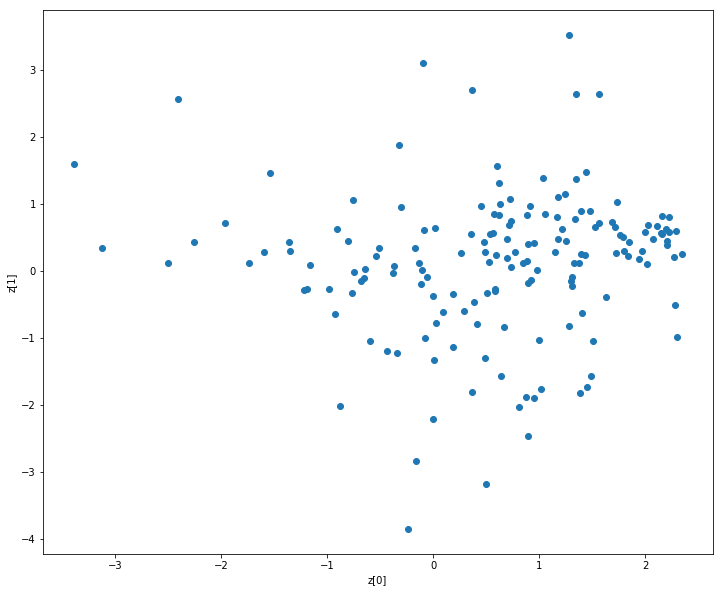

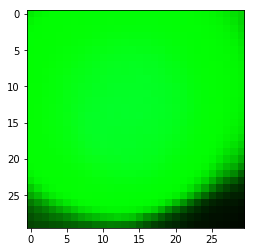

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
%matplotlib inline

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test = data
    # os.makedirs(model_name, exist_ok=True)

    # filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    # plt.savefig(filename)
    plt.show()
    
    z_sample = np.array([[2, -4]])
    x_decoded = decoder.predict(z_sample)
    image = x_decoded[0].reshape(30, 30, 3)
    plt.imshow(image)
    plt.show()


# load dataset
x_train = x_train_pos
x_test = x_test_pos

original_dim = 30 * 30 * 3
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 32
latent_dim = 2
epochs = 120

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

trained=True

if not trained:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('saved_models/vae_cnv_pos.h5')
else:
    vae.load_weights('saved_models/vae_cnv_pos.h5', by_name=False)
    
models = (encoder, decoder)
data = (x_test)
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

In [6]:
samp = 30

vae_pos = np.zeros((samp * samp, 30, 30, 3))
grid_x = np.linspace(-2, 2, samp)
grid_y = np.linspace(-2, 2, samp)

for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            vae_pos[i * samp + j] = x_decoded[0].reshape(30, 30, 3)
            
print(vae_pos.shape)

(900, 30, 30, 3)


## 2. VAE for cnv_neg

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2700)         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          1382912     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

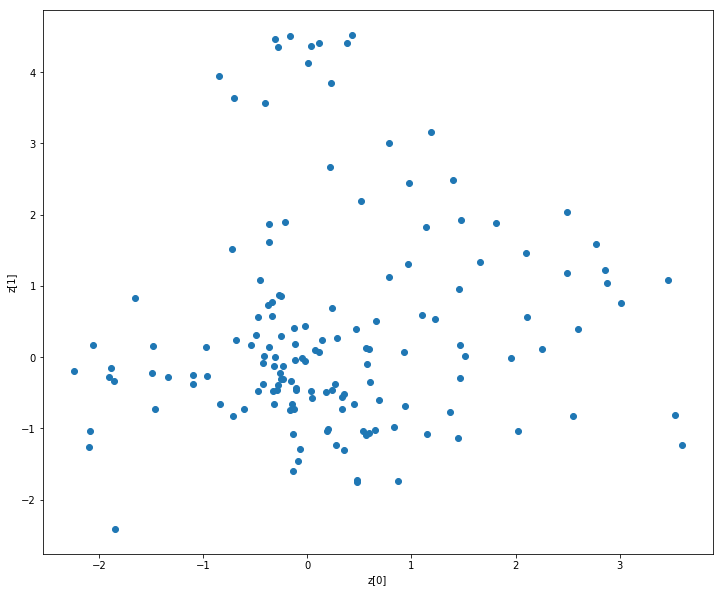

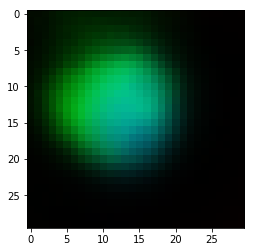

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
%matplotlib inline

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test = data
    # os.makedirs(model_name, exist_ok=True)

    # filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    # plt.savefig(filename)
    plt.show()
    
    z_sample = np.array([[2, -4]])
    x_decoded = decoder.predict(z_sample)
    image = x_decoded[0].reshape(30, 30, 3)
    plt.imshow(image)
    plt.show()


# load dataset
x_train = x_train_neg
x_test = x_test_neg

original_dim = 30 * 30 * 3
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 32
latent_dim = 2
epochs = 80

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

trained=True

if not trained:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('saved_models/vae_cnv_neg.h5')
else:
    vae.load_weights('saved_models/vae_cnv_neg.h5', by_name=False)
    
models = (encoder, decoder)
data = (x_test)
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

In [8]:
samp = 30

vae_neg = np.zeros((samp * samp, 30, 30, 3))
grid_x = np.linspace(-2, 2, samp)
grid_y = np.linspace(-2, 2, samp)

for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            vae_neg[i * samp + j] = x_decoded[0].reshape(30, 30, 3)
            
print(vae_neg.shape)

(900, 30, 30, 3)


## 3. Use VAE generated data as augmentation

In [13]:
x_train = np.concatenate((x_train_pos, vae_pos, x_train_neg, vae_neg), axis=0)
x_test = np.concatenate((x_test_pos, x_test_neg), axis=0)

y_train = np.concatenate(((np.ones(x_train_pos.shape[0] + vae_pos.shape[0], dtype=int), 
                           np.zeros(x_train_neg.shape[0] + vae_neg.shape[0], dtype=int))))
y_test = np.concatenate((np.ones(x_test_pos.shape[0], dtype=int), np.zeros(x_test_neg.shape[0], dtype=int)))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3347, 30, 30, 3)
(3347,)
(312, 30, 30, 3)
(312,)


In [14]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 2
epochs = 25
data_augmentation = False

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data, split between train and test sets:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
# else:
#     print('Using real-time data augmentation.')
#     # This will do preprocessing and realtime data augmentation:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         zca_epsilon=1e-06,  # epsilon for ZCA whitening
#         rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#         # randomly shift images horizontally (fraction of total width)
#         width_shift_range=0.1,
#         # randomly shift images vertically (fraction of total height)
#         height_shift_range=0.1,
#         shear_range=0.,  # set range for random shear
#         zoom_range=0.,  # set range for random zoom
#         channel_shift_range=0.,  # set range for random channel shifts
#         # set mode for filling points outside the input boundaries
#         fill_mode='nearest',
#         cval=0.,  # value used for fill_mode = "constant"
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False,  # randomly flip images
#         # set rescaling factor (applied before any other transformation)
#         rescale=None,
#         # set function that will be applied on each input
#         preprocessing_function=None,
#         # image data format, either "channels_first" or "channels_last"
#         data_format=None,
#         # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0.0)

#     # Compute quantities required for feature-wise normalization
#     # (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=3)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Train on 3347 samples, validate on 312 samples
Epoch 1/25
3347/3347 [==============================] - 11s 3ms/step - loss: 0.8681 - acc: 0.6050 - val_loss: 0.7645 - val_acc: 0.7564
Epoch 2/25
3347/3347 [==============================] - 10s 3ms/step - loss: 0.8034 - acc: 0.6119 - val_loss: 0.6603 - val_acc: 0.7660
Epoch 3/25
3347/3347 [==============================] - 10s 3ms/step - loss: 0.7888 - acc: 0.6056 - val_loss: 0.7118 - val_acc: 0.7756
Epoch 4/25
3347/3347 [==============================] - 10s 3ms/step - loss: 0.7643 - acc: 0.6232 - val_loss: 0.7452 - val_acc: 0.7564
Epoch 5/25
3347/3347 [==============================] - 10s 3ms/step - loss: 0.7653 - acc: 0.6164 - val_loss: 0.8085 - val_acc: 0.7692
Epoch 6/25
3347/3347 [==============================] - 10s 3ms/step - loss: 0.7348 - acc: 0.6244 - val_loss: 0.6422 - val_acc: 0.7660
Epoch 7/25
3347/3347 [==============================] - 10s 3ms/step - loss: 0.7415 - acc: 0.6358 - val_loss: 0.76